In [1]:
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Resize, Compose

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
mps_avail = torch.backends.mps.is_available()
device = torch.device("mps" if mps_avail else "cpu")
if torch.cuda.is_available(): device = torch.device("cuda")
device

device(type='mps')

In [3]:
class Inception(nn.Module):
    # output channels 
    def __init__(self, in_channels: int, bc1: int, bc2: [], bc3: [], bc4: int):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc1, kernel_size=1),
            nn.ReLU()
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc2[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=bc2[0], out_channels=bc2[1], kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.b3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=bc3[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=bc3[0], out_channels=bc3[1], kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=in_channels, out_channels=bc4, kernel_size=1)
        )

    def forward(self, x):
        return torch.concat(
            (self.b1(x), self.b2(x), self.b3(x), self.b4(x)),
            dim=1
        )
     
sample = torch.rand((1,1,28,28))
model = Inception(1, 6, [3, 6], [4, 6], 6)
print(sample.shape, "--->", model(sample).shape)

torch.Size([1, 1, 28, 28]) ---> torch.Size([1, 24, 28, 28])


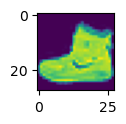

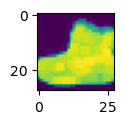

In [4]:
x = FashionMNIST(root="../datasets/", train=True, transform=ToTensor()).data[0].unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float)
plt.figure(figsize=(1,1))
plt.imshow(x.squeeze())
plt.figure(figsize=(1,1))
plt.imshow(F.max_pool2d(input=x, kernel_size=3, stride=1, padding=1).squeeze())

In [5]:
class MiniGoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1, stride=1),
            nn.ReLU(),
            
            Inception(3, 16, [8, 16], [8, 16], 16),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14x14

            Inception(16*4, 8, [12, 8], [12, 8], 8),
            nn.MaxPool2d(kernel_size=2, stride=2), # 7x7

            Inception(8*4, 4, [6, 4], [6, 4], 4),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1), # 4,4
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=4*4, out_features=10)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [6]:
BS = 32

train_dataloader = DataLoader(
    FashionMNIST(root="../datasets/", train=True, transform=ToTensor()),
    batch_size=BS, shuffle=True
)
test_dataloader = DataLoader(
    FashionMNIST(root="../datasets/", train=False, transform=ToTensor()),
    batch_size=BS, shuffle=False
)

In [7]:
model = MiniGoogLeNet()
model = model.to(device)

losses = []
accs = []

In [11]:
N_EPOCHS = 5
LR = 0.01

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model.parameters(), lr=LR,)

for epoch in tqdm(range(N_EPOCHS)):

    for batch, (x, y) in enumerate(train_dataloader):

        x = x.to(device)
        y = y.to(device)

        optim.zero_grad()

        out = model(x)
        
        acc = (out.argmax(dim=1).detach().cpu()==y.detach().cpu()).sum().item()/BS
        accs.append(acc)
        
        loss = loss_fn(out, y)
        losses.append(loss.item())

        loss.backward()
        optim.step()

        if batch % 350 == 0: print("Loss:", loss.item()/float(BS), "Acc:", acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0722171813249588 Acc: 0.03125
Loss: 0.07217010110616684 Acc: 0.15625
Loss: 0.07206542044878006 Acc: 0.0625
Loss: 0.0718916654586792 Acc: 0.09375
Loss: 0.07192250341176987 Acc: 0.125
Loss: 0.07181800901889801 Acc: 0.0625


 20%|██        | 1/5 [00:31<02:04, 31.02s/it]

Loss: 0.07199466228485107 Acc: 0.1875
Loss: 0.07165922224521637 Acc: 0.375
Loss: 0.0716841071844101 Acc: 0.15625
Loss: 0.07154367864131927 Acc: 0.25
Loss: 0.07139581441879272 Acc: 0.21875
Loss: 0.07075554132461548 Acc: 0.3125


 40%|████      | 2/5 [01:01<01:32, 30.76s/it]

Loss: 0.07070869952440262 Acc: 0.15625
Loss: 0.06843620538711548 Acc: 0.25
Loss: 0.05713677406311035 Acc: 0.28125
Loss: 0.043313685804605484 Acc: 0.5
Loss: 0.03998595476150513 Acc: 0.5
Loss: 0.035768598318099976 Acc: 0.53125


 60%|██████    | 3/5 [01:33<01:02, 31.17s/it]

Loss: 0.03609450161457062 Acc: 0.40625
Loss: 0.035513512790203094 Acc: 0.5625
Loss: 0.03233201429247856 Acc: 0.5625
Loss: 0.03686255216598511 Acc: 0.5
Loss: 0.02821444347500801 Acc: 0.75
Loss: 0.03652511164546013 Acc: 0.53125


 80%|████████  | 4/5 [02:03<00:31, 31.00s/it]

Loss: 0.0352887362241745 Acc: 0.46875
Loss: 0.027095595374703407 Acc: 0.6875
Loss: 0.02025020867586136 Acc: 0.78125
Loss: 0.029515370726585388 Acc: 0.59375
Loss: 0.02353518456220627 Acc: 0.75
Loss: 0.023229625076055527 Acc: 0.71875


100%|██████████| 5/5 [02:34<00:00, 30.93s/it]


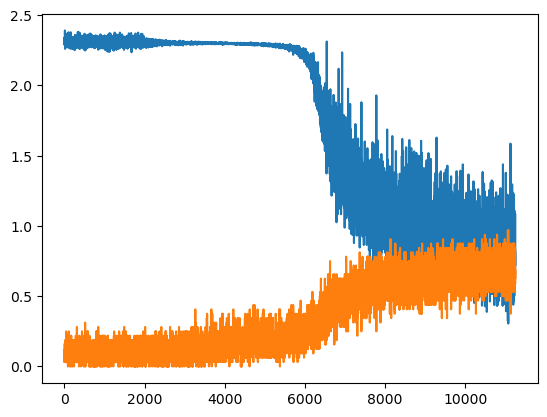

In [12]:
plt.plot(losses)
plt.plot(accs)

In [13]:
score = 0
for (x, y) in test_dataloader:
    out = model(x.to(device))
    score += (out.argmax(dim=1).detach().cpu()==y).sum().item()
print(score)

7023
